In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from data import *
from features import *
from stats import *
from preprocess import *
from model import *
from step import Step
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint
import lightning as L
import matplotlib.pyplot as plt
import pickle
import torch

In [3]:
step = Step(load_mnm_spatial)
step = Step(subset, step, key='cell', value='NIN-PFC-AD-PRE-145')
step = Step(win_cts_by_trial, step, win_start=1500, win_end=6000, win_size=125, win_stride=125)
step = Step(win_cts_by_win, step)
step = Step(tvt_split, step, num_splits=10, num_val=1, num_test=1)
step = Step(gen_samples, step, num_train=120, num_val=1, num_test=1)
data = step()

In [4]:
raw_df = step()['raw_df']
#pickle raw_df
with open('raw_df_NIN-PFC-AD-PRE-145.pkl', 'wb') as f:
    pickle.dump(raw_df, f)

In [5]:
import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.utilities").setLevel(logging.ERROR)

def train(i, drop_cols=None):
    callback = ModelCheckpoint(save_top_k=1, monitor='val_acc', mode='max')
    # mlflow.pytorch.autolog(checkpoint_monitor='val_acc', checkpoint_mode='max')

    train, val, test = data['train'][i], data['val'][i], data['test'][i]
    if drop_cols:
        cols_to_keep = [i for i in range(train.shape[1]) if i not in drop_cols]
        train = train.clone()[:, cols_to_keep]
        val = val.clone()[:, cols_to_keep]
        test = test.clone()[:, cols_to_keep]

    data_module = DataModule(*[train, val, test], one_hot_max=0.85, train_batch_size=7)
    input_size = data_module.train_dataloader().dataset[0][0].shape[0]
    model = CrossEntropyFNN(input_size, [2**10] * 4, 8)

    trainer = L.Trainer(max_epochs=10, callbacks=[callback], enable_progress_bar=False)
    trainer.fit(model, data_module)
    train_acc = trainer.logged_metrics['best_train_acc']
    val_acc = trainer.logged_metrics['best_val_acc']
    model = CrossEntropyFNN.load_from_checkpoint(callback.best_model_path)
    test_results = trainer.test(model, data_module, verbose=False) #, ckpt_path="best")

    return model, trainer, data_module, val_acc, test_results[0]['test_acc']

In [6]:
# test_accs = []
# val_accs = []
# for s in range(10):
#     model, trainer, data_module, val_acc, test_acc = train(s)
#     test_accs.append(test_acc)
#     val_accs.append(val_acc)
#     print(val_acc, test_acc)
# print(np.mean(val_accs), np.mean(test_accs))

In [7]:
test_accs = []
val_accs = []
predicted = torch.zeros((8, 8))
for i in range(10):
    model, trainer, data_module, val_acc, test_acc = train(i)
    output = model(data_module.test_dataloader().dataset[:][0])
    predicted += (output == output.max(dim=1, keepdim=True).values)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
    print(val_acc, test_acc)
print(np.mean(val_accs), np.mean(test_accs))

/Users/jason/mambaforge/envs/nda2/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


tensor(0.5000) 0.5
tensor(0.7500) 0.5
tensor(0.7500) 0.75
tensor(0.7500) 0.625
tensor(0.6250) 0.75
tensor(0.8750) 0.875
tensor(0.7500) 0.875
tensor(0.7500) 0.75
tensor(0.6250) 0.75
tensor(1.) 1.0
0.7375 0.7375


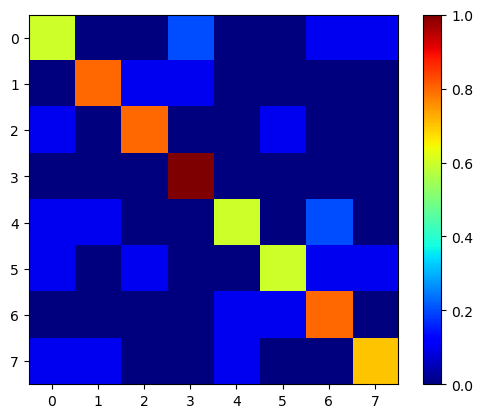

In [8]:
plt.imshow(predicted.numpy() / 10, cmap='jet')
plt.colorbar()
plt.clim(0, 1)

In [9]:
# sum the diagonal entries of predicted
predicted.diag().sum().item() / 8

7.375

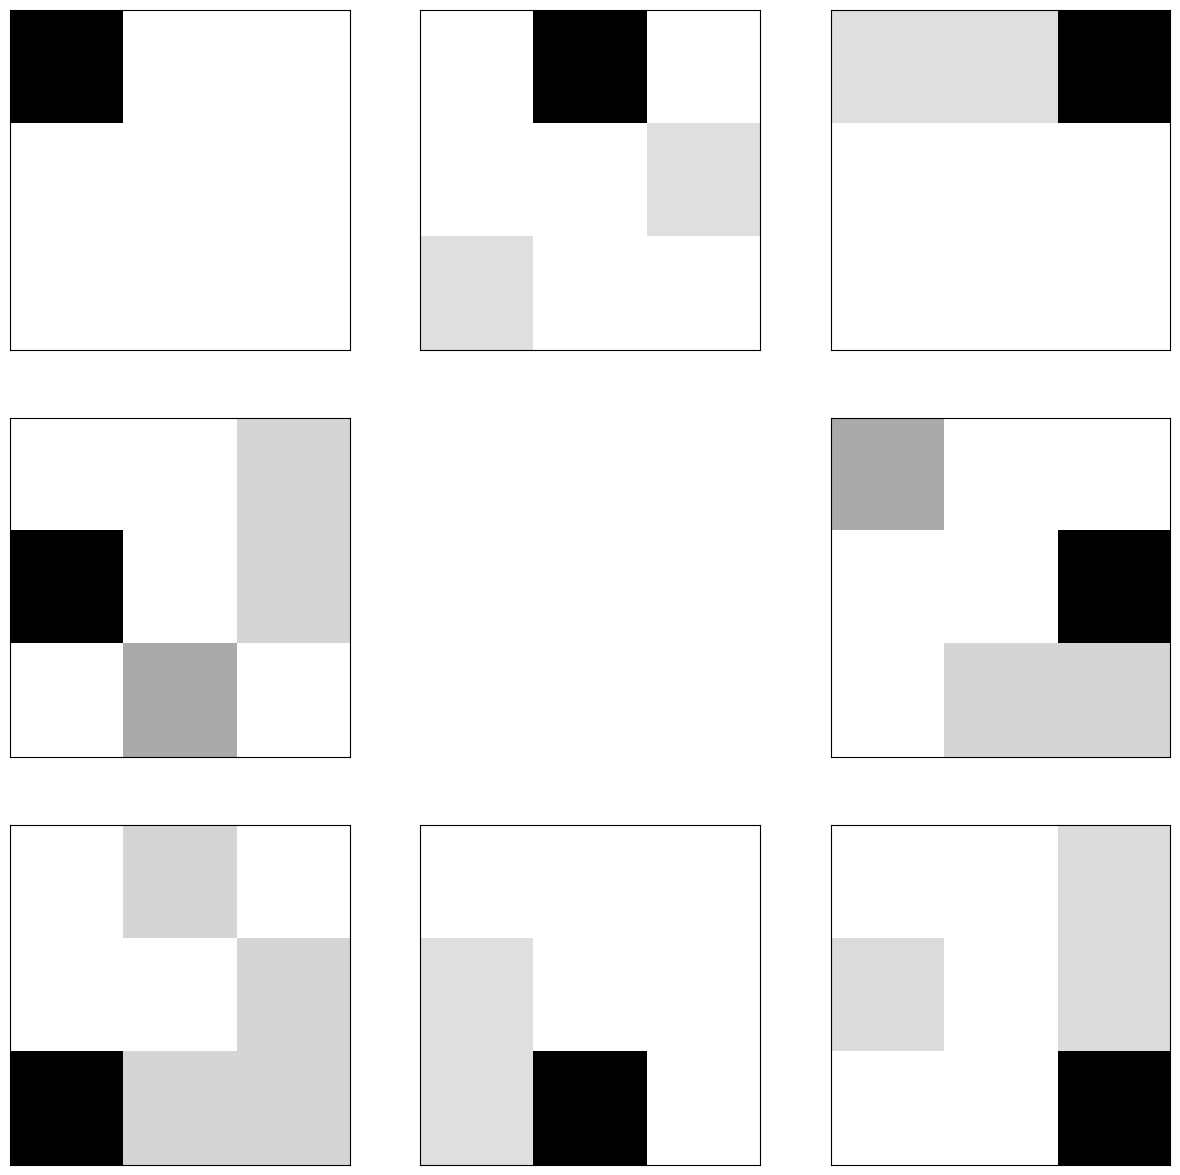

In [23]:
rows_and_cols = [[1, 2], [0, 2], [0, 1], [0, 0], [1, 0], [2, 0], [2, 1], [2, 2]]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(8):
    ax = axs[rows_and_cols[i][0], rows_and_cols[i][1]]
    pos_data = torch.zeros((3, 3))
    for j in range(8):
        pos_data[rows_and_cols[j][0], rows_and_cols[j][1]] = predicted[i, j].item()
    ax.imshow(pos_data.numpy(), cmap='binary')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

axs[1,1].axis('off')
plt.show()

In [10]:
predicted

tensor([[ 6.,  0.,  0.,  2.,  0.,  0.,  1.,  1.],
        [ 0.,  8.,  1.,  1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  8.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  6.,  0.,  2.,  0.],
        [ 1.,  0.,  1.,  0.,  0.,  6.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  8.,  0.],
        [ 1.,  1.,  0.,  0.,  1.,  0.,  0.,  7.]])